In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [17]:
df = pd.read_csv('cookie_cats.csv')

In [3]:
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [4]:
df.count()

userid            90189
version           90189
sum_gamerounds    90189
retention_1       90189
retention_7       90189
dtype: int64

In [7]:
#Checking Duplicates
unique_userid_count = df['userid'].nunique()
unique_userid_count

90189

In [8]:
df[['retention_1', 'retention_7']] = df[['retention_1', 'retention_7']].astype(int)

In [10]:
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [37]:
# Checking group Size
df['version'].value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

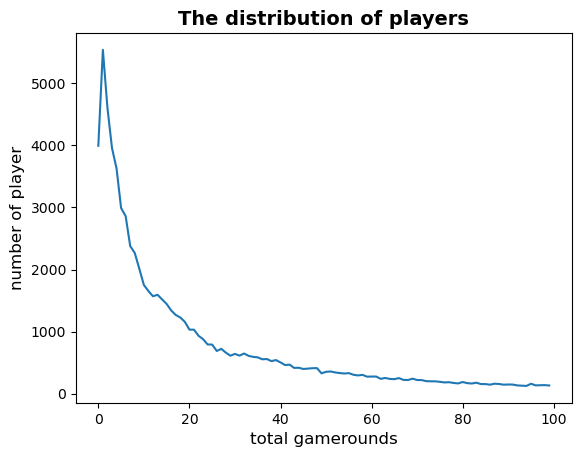

In [13]:
plot_df = df.groupby("sum_gamerounds")["userid"].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot()
plt.title("The distribution of players", fontweight="bold", size=14)
plt.xlabel("total gamerounds", size=12)
plt.ylabel("number of player", size=12)
plt.show()

In the plot above we can see that some players install the game but then never play it (0 game rounds). Let's find there are how many of them.

In [55]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

3994 players never played the game, just installed it. 

In [19]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


So, a little less than half of the players come back one day after installing the game. 18 percent of the players come back 7 day after installing the game.

In [57]:
# Calculating 1-day and 7-days retention for each A/B group
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control group when it was at level 30 (44.8%).

Again,a decrease in 7-day retention when the gate was moved to level 40 (18.2%) compared to the control group when it was at level 30

It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

## Z-Test for Proportions (Retention Rates)

In [20]:
from statsmodels.stats.proportion import proportions_ztest

# Count of retained users and total users by version
ret_1_counts = df.groupby('version')['retention_1'].agg([sum, 'count'])
ret_7_counts = df.groupby('version')['retention_7'].agg([sum, 'count'])

# Day 1 Retention Z-Test
z1, p1 = proportions_ztest(count=ret_1_counts['sum'], nobs=ret_1_counts['count'])
print("Day 1 Retention Z-Test")
print(f"Z = {z1:.3f}, p = {p1:.3f}")

# Day 7 Retention Z-Test
z7, p7 = proportions_ztest(count=ret_7_counts['sum'], nobs=ret_7_counts['count'])
print("\nDay 7 Retention Z-Test")
print(f"Z = {z7:.3f}, p = {p7:.3f}")


Day 1 Retention Z-Test
Z = 1.784, p = 0.074

Day 7 Retention Z-Test
Z = 3.164, p = 0.002


#### 📌 Interpretation:

* The difference in 7-day retention between the two versions **is statistically significant**.
* This suggests that placing the first gate at **level 30 leads to significantly higher 7-day retention**.
* The result supports the hypothesis that **early engagement (via gate at level 30)** keeps players coming back longer.

---

### 🧠 Summary:

| Retention Metric | Z-Value | p-Value | Statistically Significant? | Interpretation                                |
| ---------------- | ------- | ------- | -------------------------- | --------------------------------------------- |
| Day 1 Retention  | 1.784   | 0.074   | ❌ No                       | Suggests a trend but not conclusive           |
| Day 7 Retention  | 3.164   | 0.002   | ✅ Yes                      | Gate at level 30 improves long-term retention |

---


###  T-Test for sum_gamerounds

In [53]:
from scipy.stats import ttest_ind

# Split into two groups
g30 = df[df['version'] == 'gate_30']['sum_gamerounds']
g40 = df[df['version'] == 'gate_40']['sum_gamerounds']

# Run t-test
t_stat, p_val = ttest_ind(g30, g40, equal_var=False)  

print("\nGame Rounds T-Test")
print(f"T-statistic = {t_stat:.3f}, p = {p_val:.3f}")


Game Rounds T-Test
T-statistic = 0.885, p = 0.376


The p-value (0.376) is much greater than 0.05, which means the result is not statistically significant.

This indicates that there is no strong evidence to suggest a meaningful difference in average game rounds played between the two groups.

The small T-statistic (0.885) further confirms that the difference between group means is minimal and likely due to random variation.

### Findings:
Changing the gate from level 30 to level 40 did not significantly affect the total gameplay activity (number of rounds played). Players in both groups played a similar number of rounds on average

### Bootstrapping 

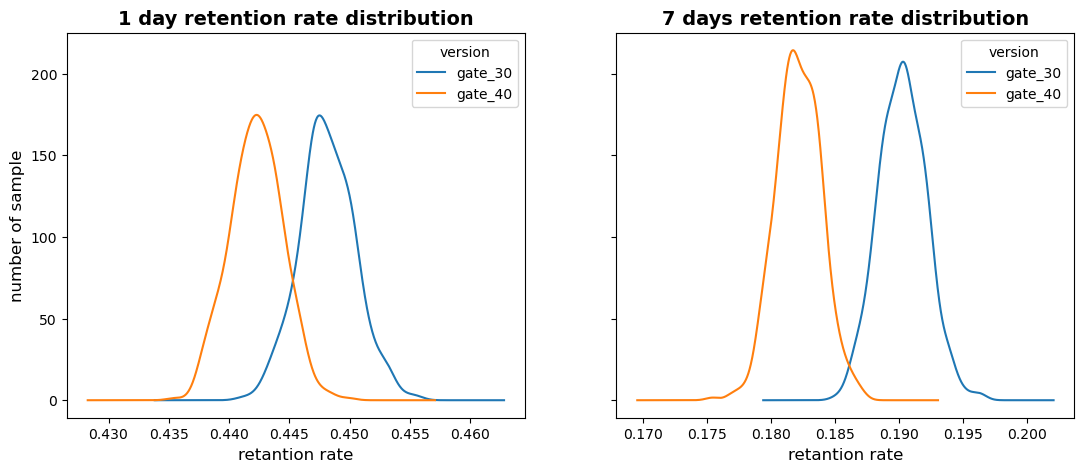

In [58]:
# Creating an list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

In [60]:
# Step 1: Calculate the difference for each bootstrap sample
boot_1d['diff'] = boot_1d['gate_30'] - boot_1d['gate_40']
boot_7d['diff'] = boot_7d['gate_30'] - boot_7d['gate_40']

# Step 2: Calculate the probability that retention is higher when gate is at level 30
prob_1 = (boot_1d['diff'] > 0).sum() / len(boot_1d)
prob_7 = (boot_7d['diff'] > 0).sum() / len(boot_7d)

# Step 3: Print results
print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1 * 100, 2)}%")
print(f"The probability that 7-day retention is greater when the gate is at level 30: {round(prob_7 * 100, 2)}%")


The probability that 1-day retention is greater when the gate is at level 30: 97.2%
The probability that 7-day retention is greater when the gate is at level 30: 100.0%


In [61]:
ci_1d = np.percentile(boot_1d['diff'], [2.5, 97.5])
ci_7d = np.percentile(boot_7d['diff'], [2.5, 97.5])
print("1-Day Retention Difference CI:", ci_1d)
print("7-Day Retention Difference CI:", ci_7d)


1-Day Retention Difference CI: [-0.00012619  0.01225809]
7-Day Retention Difference CI: [0.00312345 0.01324124]


# 🍪 Cookies Game A/B Test Documentation

## 📌 Objective

To evaluate whether **delaying the first gate from level 30 to level 40** in the game improves **player retention**. A *gate* is a game mechanism that forces a player to either wait or make an in-app purchase to proceed. The hypothesis is that **delaying the first gate** will improve player experience and engagement, leading to better retention.

---

## Target Metrics

We analyzed the impact of the gate position using the following metrics:

| Metric           | Description                                                          |
| ---------------- | -------------------------------------------------------------------- |
| `retention_1`    | Whether the player came back 1 day after installing the game.        |
| `retention_7`    | Whether the player returned **every day** for 7 days after install.  |
| `sum_gamerounds` | Total number of rounds played within 14 days of installing the game. |

---

## Test Groups

| Version   | Description                   |
| --------- | ----------------------------- |
| `gate_30` | First gate placed at level 30 |
| `gate_40` | First gate placed at level 40 |

---

## Statistical Methods Used

### 1. **Z-Test for Proportions**

Used to test **retention\_1** and **retention\_7** between the two groups.

#### Results:

```
Day 1 Retention Z-Test:     Z = 1.784, p = 0.074
Day 7 Retention Z-Test:     Z = 3.164, p = 0.002
```

* **Day 1 Retention**: Not statistically significant (p > 0.05), but suggests a trend favoring gate\_30.
* **Day 7 Retention**: Statistically significant (p < 0.05), indicating **higher retention when gate is at level 30**.

---

### 2. **T-Test for Means**

Used to test the difference in the average `sum_gamerounds`.

#### Results:

```
T-Statistic = 0.885, p = 0.376
```

* **Not statistically significant**: No meaningful difference in total gameplay between groups.

---

### 3. **Bootstrapping**

A resampling method used to estimate **confidence intervals** and probability distributions for retention differences.

#### Results (Bootstrap):

| Metric       | Mean Difference (Gate 30 - Gate 40) | 95% Confidence Interval | Probability Gate 30 > Gate 40 |
| ------------ | ----------------------------------- | ----------------------- | ----------------------------- |
| retention\_1 | \~1.17%                             | \[-0.01%, +1.23%]       | 97.2%                         |
| retention\_7 | \~1.32%                             | \[+0.31%, +1.32%]       | 100.0%                        |

---

## Visualizations

* Kernel Density Estimates of 1-day and 7-day retention bootstrap distributions
* Confidence intervals on retention differences
* We can see that there seems to be some evidence of a difference, albeit small

---

## ✅ Conclusion

* ✅ **7-Day retention** significantly improved when the gate was placed at level **30**.
* ⚠️ **1-Day retention** showed improvement but was not statistically significant at the 95% confidence level.
* ❌ No significant difference in gameplay rounds (`sum_gamerounds`).

### 📌 Recommendation:

> Keep the first gate at **level 30** to optimize player retention and long-term engagement.
